### Get Latest log in folder 

In [ ]:
import plottinglib.plotting_vr_logs as pl
import os
import cellworld as cw
import numpy as np

### Checking measurements of occlusion spawning location

- all in meters

In [60]:
# [distance from door, obstacle height on y]
import math
msmts_m = {'1': [20.97, 1.8],
         '3': [21.81, 1.82],
         '4': [23.25, 1.8],
         '5': [13.56, 1.79]
      }

scale = 14.336 
hab_diam = 2.35 # m 
scaled_diam = scale*hab_diam # diam of VR habitat --> meters 
occ_d_edge_true = 6.384 / 100 # from onshape: cm -> m
occ_y_true = 12.700000 / 100 # from onshape: cm -> m 
print(scaled_diam)
occ_y_error = []
d_edge_vr   = []
occ_y_vr    = []

for key, val in msmts_m.items():
    d_edge_vr.append(val[0] / scaled_diam)
    
    # occlusion height (y-axis, edge to edge)
    occ_y_vr.append(val[1] / scaled_diam)
    

    # val.append((val[0]/scaled_diam)+occ_d_edge_true)
    # val.append((val[1]/scaled_diam)) # scaled height of occlusion, should match occ_d_edge 
    # occ_y_error.append((val[3] - occ_y_true)/occ_y_true) 

    # print(val)
print(occ_y_vr)
print(occ_y_true)
# print(f'Occlusion height (y, edge-edge) error: {(sum(occ_y_error)/len(occ_y_error)*100):0.2f}', )

33.6896
[0.053428951367781155, 0.054022606382978726, 0.053428951367781155, 0.05313212386018237]
0.127


In [49]:
12.7 / (100*2.35)

0.05404255319148936

In [ ]:
def get_newest_file_in_folder(folder_path:str='../logs', extension="*."):
    import os
    import glob
    if extension == "*":
        search_pattern = os.path.join(folder_path, "*")
    else:
        search_pattern = os.path.join(folder_path, f"*.{extension}")
    files = glob.glob(search_pattern)
    if not files:
        return None
    
    newest_file = max(files, key=os.path.getmtime)
    return newest_file

folder_path = os.path.join('..', 'logs')  # Replace with the path to your folder
extension = "json"  # Replace with the desired file extension (e.g., 'txt', 'jpg', 'py')
newest_file = get_newest_file_in_folder(folder_path, extension)
print(newest_file)

12


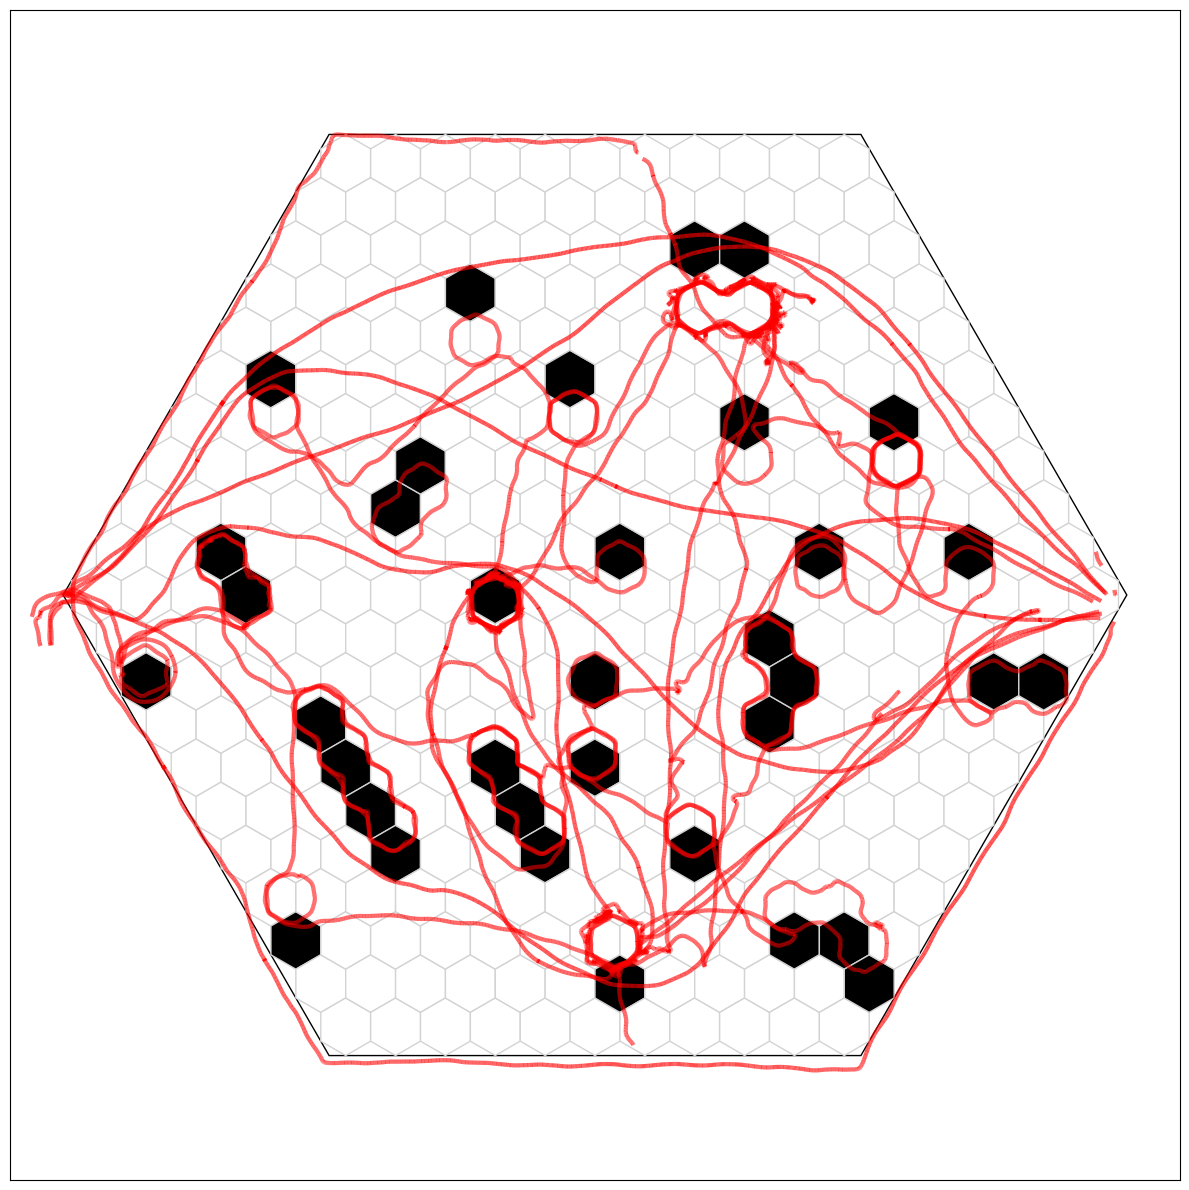

In [59]:
# p = pl.ExperimentPlot()
# p.basic_plot('../logs/l.json')
import math

filepath = '../logs/l.json'
if not filepath: raise ValueError('File is NONE!')
w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
d = cw.Display(w, fig_size=(12,12), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")

n     = 0
t_sum = 0

exp = cw.Experiment.load_from_file(filepath)

# Define hexagonal world bounds
print(len(exp.episodes))

def scale_legacy_y(y):
    return y * 0.5 * math.sqrt(3) + 0.5 - math.sqrt(3) / 4

def inverse_scale_legacy_y(scaled_y):
    return (scaled_y - 0.5 + math.sqrt(3) / 4) / (0.5 * math.sqrt(3))

for idx in range(len(exp.episodes)):
    episode = exp.episodes[idx]
    preyt = episode.trajectories.get_agent_trajectory('prey')
    # prey_scaled_inv = preyt.copy()
    # prey_scaled = preyt.copy()
    for step in preyt: 
        step.location.y = scale_legacy_y(step.location.y)
        
    d.add_trajectories(preyt, colors = {'prey': 'red'}, alphas = {'prey': .7}, zorder = 7)
    # d.add_trajectories(prey_scaled, colors = {'prey': 'red'}, alphas = {'prey': .7}, zorder = 7)
    # d.add_trajectories(prey_scaled_inv, colors = {'prey': 'green'}, alphas = {'prey': .7}, zorder = 7)
    # if idx == 2: 
    #     break
    # d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
    n+=1 
    t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

### basic plot

In [ ]:
import cellworld as cw
import matplotlib.pyplot as plt
import numpy as np
# Load world and experiment data
file = "..\\logs\\malcolm_03072025_100839.json"

w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")

n     = 0
t_sum = 0

exp = cw.Experiment.load_from_file(file)

# Define hexagonal world bounds

for idx in range(len(exp.episodes)):
    episode = exp.episodes[idx]
    preyt = episode.trajectories.get_agent_trajectory('prey')
    predt = episode.trajectories.get_agent_trajectory('predator')
        
    if len(episode.captures)<1:
        print(f'Episode {idx} has 0 captures ({episode.captures}). Skipping...')
        continue
    
    d.add_trajectories(preyt, colors = {'prey': 'green'}, alphas = {'prey': .7}, zorder = 7)
    d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
    
    # summary info 
    n+=1 
    t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

print(f'Total time: {t_sum:.3f} s ({t_sum/60:.3f} min)')
print(f'Average time per episode: {t_sum / n :.3f} s')

### Plotting

In [ ]:
## show summary info of trajectories 
# show time steps 

def detect_outliers(array):
    import numpy as np 
    mean = np.mean(array)
    std = np.std(array)
    lower_bound = mean - std
    upper_bound = mean + std
    outliers = array[(array < lower_bound) | (array > upper_bound)]
    
    if len(outliers) > 0:
        return f"Outliers detected: {outliers}"
    else:
        return "No outliers detected"
    
def show_info(filepath:str=None):
    import numpy as np
    if not filepath: print("need a filepath"); return

    e = Experiment.load_from_file(filepath)
    if e is None: 
        print("No experiment found: e is NONE")
        return 
    
    w = World.get_from_parameters_names('hexagonal',"canonical",e.occlusions)
    subject_str = 'prey'
    scalar = 1.0
    mv = 1.0
    print(f'Episode count: {len(e.episodes)}')
    grads = []
    for i, episode in enumerate(e.episodes[:]):
        t = episode.trajectories
        tprey = t.get_agent_trajectory('prey')
        tpred = t.get_agent_trajectory('predator')
        
        frame_list = tprey.get('frame')
        nv = [f/(max(frame_list)) for f in frame_list]
        grad = np.gradient(nv)
        grads.append(grad)

    return grads
    
g = show_info(file)

In [ ]:
# file = '/mnt/c/Users/MacIver/Research/BotEvade/CellworldServer/main/cpp/robot_controller/logs/labtest_08202024_164619.json'
e = cw.Experiment.load_from_file(file)
w = cw.World.get_from_parameters_names('hexagonal',"canonical",e.occlusions)
subject_str = 'prey'
scalar = 1.0
mv = 1.0
print(f'Episode count: {len(e.episodes)}')
import numpy as np 
gp = []
gpp = []
for i, episode in enumerate(e.episodes[:]):
    t = episode.trajectories
    tprey = t.get_agent_trajectory('prey')
    frame_list = tprey.get('frame')
    gpp.append(tprey.get_locations())
    
xt = tprey.get('location').get('x')
tjson = tprey.get('time_stamp')
t = np.array(list(tjson)) - tjson[0]
plt.plot(t,xt,'--o')
# gpp = np.gradient(np.gradient(xt))
# print(gpp)
# print(np.where(np.nonzero(gpp)))
# xt = tprey.get_locations().get('prey').get('y')